In [4]:
import xarray as xr
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import seaborn as sns
%matplotlib inline
import tqdm
### Ouvrir le fichier des jours sélectionés
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes


### OPAR LIO3T & LI1200

In [153]:
all_residus = np.array([])
all_time = np.array([])
lidars='LI1200'
for l in sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF', lidars).glob('**/*residus.txt')):
    with open(l, 'r') as f:
        print(l)
        data = np.array([line.strip() for line in f.readlines()])
        residus = np.array([float(data[i].split(',')[0]) for i in range(1, len(data))])
        time = np.array([datetime.strptime(data[i].split(',')[1].split('.')[0], '%Y-%m-%dT%H:%M:%S') for i in range(1, len(data))])
#         f, ax = plt.subplots(figsize=[10,6])
#         plt.rcParams['savefig.facecolor']='white'
#         ax.scatter(time, residus)
#         ax.set(title = str(l), ylabel='Residus integral on altitude (by profile)', xlabel='time')
#         plt.savefig(Path('/homedata/nmpnguyen/OPAR/Processed/RF/', l.name.split('residus.txt')[0], l.name.split('.txt')[0]+'.png'))
#         plt.close()
    all_residus = np.append(all_residus, residus)
    all_time = np.append(all_time, time)

/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-12/2019-01-12_residus.txt
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-14/2019-01-14_residus.txt
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-02-11/2019-02-11_residus.txt
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-03-04/2019-03-04_residus.txt
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-03-05/2019-03-05_residus.txt
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-04-23/2019-04-23_residus.txt


In [136]:
# print(all_time[~np.isnan(all_residus)])

mu, std = stats.norm.fit(all_residus[~np.isnan(all_residus)])
print(mu, std)

-0.0009275098039215687 0.00036826113027431075


<BarContainer object of 100 artists>


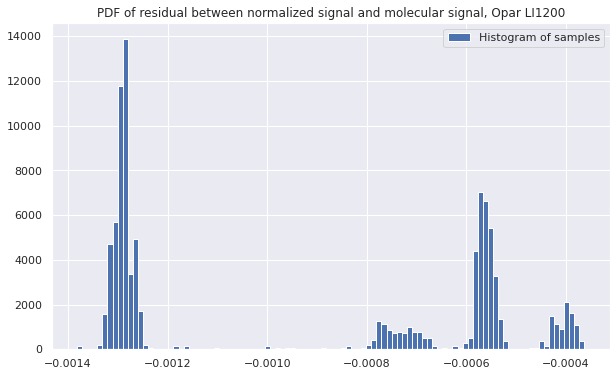

In [148]:
f, ax = plt.subplots(figsize=[10,6])
# counts, bins = np.histogram(all_residus, density=True)
(n, bins, patches )= ax.hist(all_residus[~np.isnan(all_residus)], bins=100, density=True,
                             label="Histogram of samples")
# Compute probability density function
# bin_centers = 0.5*(bins[1:] + bins[:-1])
# pdf = stats.norm.pdf(x = bin_centers, loc=mu, scale=std)
# ax.plot(bin_centers, pdf, label="PDF",color='black') #Plot PDF
ax.legend()#Legend entries
ax.set_title(f'PDF of residual between normalized signal and molecular signal, Opar {lidars}')
print(patches)

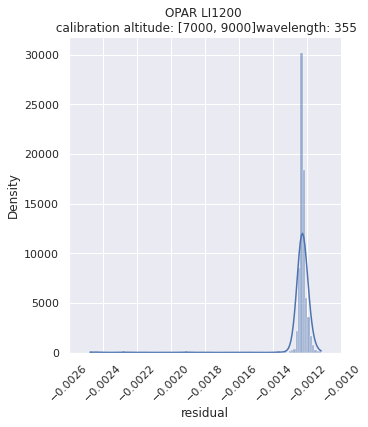

In [160]:
sns.set(rc={'figure.figsize': (12, 9)})
g = sns.displot(all_residus, stat="density", kde=True, bins=100)#
g.set(title=f'OPAR {lidars} \n {data[0]}',
     xlabel = 'residual')
g.set_xticklabels(rotation=45)  
# g.set(xlim=(0.001, 0.002))
plt.savefig(Path('/homedata/nmpnguyen/OPAR/Processed/RF', lidars,'residus-report-'+data[0]+'.png'))


In [43]:
def residus_alt(new, channelnb):
    limite = np.where((new['range']>5)&(new['range']<20))[0]
    residues = new.isel(channel=channelnb, range=limite)['calibrated'] - new.isel(channel=channelnb, range=limite)['simulated']
    residue = np.nansum(residues, axis=1)
#     code = np.zeros_like(residue)
#     code[residue>0.0005] = 2
#     code[(residue>-0.0005)&(residue<0.0005)] = 1
    return residue, residues #code#


In [59]:
listfiles = sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/clouds').glob('2020*RF_v1.nc'))
r_allClouds = []; 
time_clouds=np.array([], dtype='datetime64[ns]'); time_clearsky=np.array([], dtype='datetime64[ns]')
for path in listfiles: 
    file = xr.open_dataset(path)
    r = residus_alt(file, 1)
    r_allClouds = np.concatenate((r_allClouds, r[0]))
    time_clouds = np.concatenate((time_clouds, file['time'][r[0]>0.0005].values))
    time_clearsky = np.concatenate((time_clearsky, file['time'][(r[0]>-0.0005)&(r[0]<0.0005)].values))
    limiteZ = (file['range']>5)&(file['range']<20)

listfiles = sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/clearsky').glob('2020*RF_v1.nc'))
r_allClear = []; 
# time_clouds=np.array([], dtype='datetime64[ns]'); time_clearsky=np.array([], dtype='datetime64[ns]')
for path in listfiles: 
    file = xr.open_dataset(path)
    r = residus_alt(file, 1)
    r_allClear = np.concatenate((r_allClear, r[0]))
    time_clouds = np.concatenate((time_clouds, file['time'][r[0]>0.0005].values))
    time_clearsky = np.concatenate((time_clearsky, file['time'][(r[0]>-0.0005)&(r[0]<0.0005)].values))
    limiteZ = (file['range']>5)&(file['range']<20)    

In [194]:
H1 = np.histogram(r_allClear, range=[-0.001, 0.001], bins=100)
H2 = np.histogram(r_allClouds, range=[-0.005, 0.005], bins=100)

print(H1)
df= pd.DataFrame({'residu_int':np.concatenate([r_allClear, r_allClouds]),
                 'flag': np.concatenate([['clear']*len(r_allClear), ['cloud']*len(r_allClouds)])})

print(df)

# # Normalize
# kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)

# f2, ax = plt.subplots()
# ax.hist(df.loc[df.flag=='cloud', 'residu_int'], **kwargs, color='g', range=[-0.005, 0.005],label='cloud')
# ax.hist(df.loc[df.flag=='clear', 'residu_int'], **kwargs, color='b', range=[-0.005, 0.005],label='clear sky')

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         1,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,
         1,   1,   1,   2,  13, 508, 708, 650, 501,   3,   2,   1,   0,
         0,   1,   0,   1,   0,   0,   0,   0,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0]), array([-1.0e-03, -9.8e-04, -9.6e-04, -9.4e-04, -9.2e-04, -9.0e-04,
       -8.8e-04, -8.6e-04, -8.4e-04, -8.2e-04, -8.0e-04, -7.8e-04,
       -7.6e-04, -7.4e-04, -7.2e-04, -7.0e-04, -6.8e-04, -6.6e-04,
       -6.4e-04, -6.2e-04, -6.0e-04, -5.8e-04, -5.6e-04, -5.4e-04,
       -5.2e-04, -5.0e-04, -4.8e-04, -4.6e-04, -4.4e-04, -4.2e-04,
       -4.0e-04, -3.8e-04, -3.6e-04, -3.4e-04, -3.2e-04, -3.0e-04,
       -2.8e-04, -2.6e-04, -2.4e-04, -2

13179 2382 10797
13179 2382 10797


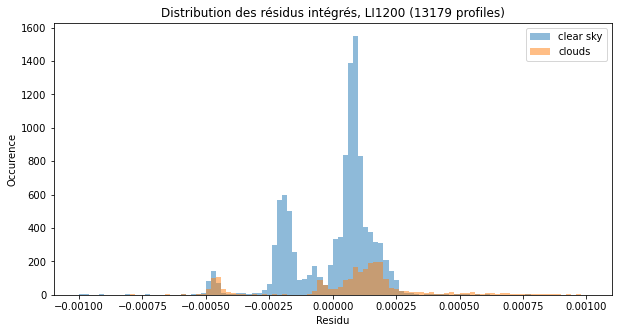

In [70]:
totalprofiles = len(r_allClouds)+ len(r_allClear)
print(totalprofiles, len(r_allClouds), len(r_allClear))

f1, ax = plt.subplots(figsize=[10,5])
(n, bins, patches )= ax.hist(r_allClear, bins=100, range=[-0.001, 0.001],density=False, stacked=True, label='clear sky', alpha=0.5)
(n, bins, patches )= ax.hist(r_allClouds, bins=100, range=[-0.001, 0.001], density=False, stacked=True, label='clouds', alpha=0.5)
ax.legend(loc='best')
ax.set(title = f'Distribution des résidus intégrés, LI1200 ({totalprofiles} profiles)',
      ylabel='Occurence', xlabel='Residu')
# ax.set_xlim(-0.002, 0.002)


# Normalize by total profiles 
totalprofiles = len(r_allClouds)+ len(r_allClear)
print(totalprofiles, len(r_allClouds), len(r_allClear))
Hclear = np.histogram(r_allClear, bins=100, range=[-0.005, 0.005])
Hclouds = np.histogram(r_allClouds, bins=100, range=[-0.005, 0.005])

dtHistogram = pd.DataFrame({'bins': np.linspace(-0.005, 0.005, 100), 
                           'probas_clear': Hclear[0]/totalprofiles,
                           'probas_clouds': Hclouds[0]/totalprofiles})


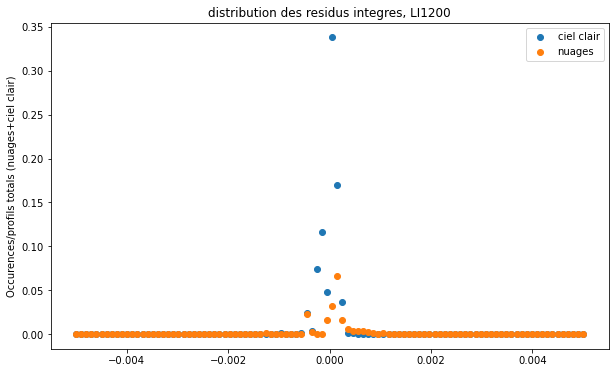

In [71]:

fg, ax = plt.subplots(figsize=[10,6])
ax.scatter(x= dtHistogram['bins'], y=dtHistogram['probas_clear'], label='ciel clair')
ax.scatter(x= dtHistogram['bins'], y=dtHistogram['probas_clouds'], label='nuages')
ax.set(ylabel='Occurences/profils totals (nuages+ciel clair)', 
       title='distribution des residus integres, LI1200')
ax.legend()

No handles with labels found to put in legend.


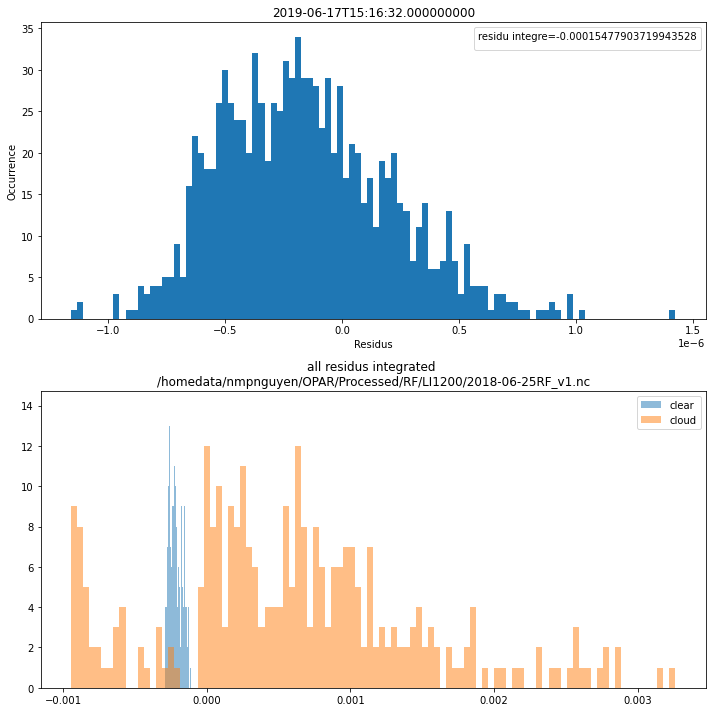

In [110]:
dt = xr.open_dataset('/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-06-17RF_v1.nc')
r = residus_alt(dt, 1)
dt2 = xr.open_dataset('/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-21RF_v1.nc')
r2 = residus_alt(dt2, 1)
# flagcode = residus_alt(dt, 1)
# print(flagcode!=0)
# dt['calibrated'].isel(time=np.where(flagcode!=0)[0], channel=1)
# print(r[1][0,:])
# print((dt['calibrated']-dt['simulated']).isel(time=0, channel=1, range=limiteZ))
# limiteZ = (dt['range']>5)&(dt['range']<20)
# f, (ax,ax2) = plt.subplots(figsize=[12,7],ncols=2)
# dt['calibrated'].isel(time=10, channel=1, range=limiteZ).plot(y='range', ylim=(0,20), ax=ax, label='calibrated', c='r')
# dt['simulated'].isel(time=10, channel=1, range=limiteZ).plot(y='range', ylim=(0,20), ax=ax, label='simulated', c='b')
# ax.legend()
# (dt['calibrated']-dt['simulated']).isel(time=10, channel=1, range=limiteZ).plot(y='range', ylim=(0,20), ax=ax2)
# ax2.axvline(0, c='k')

f, (ax, ax2) = plt.subplots(figsize=[10,10], nrows=2)
# counts, bins = np.histogram(all_residus, density=True)
(n, bins, patches )= ax.hist(r[1][10,:], bins=100, density=False) 
ax.legend(title=f'residu integre={str(r[0][10])}', loc='best')
ax.set(ylabel='Occurrence', xlabel='Residus', title=str(dt['time'][10].values))
(n, bins, patches )= ax2.hist(r[0], bins=100, density=False, label='clear', alpha=0.5) 
(n, bins, patches )= ax2.hist(r2[0], bins=100, density=False, label='cloud', alpha=0.5) 
ax2.legend()
ax2.set(title = 'all residus integrated \n/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2018-06-25RF_v1.nc')
plt.tight_layout()

In [155]:
time_clouds

array(['2020-01-07T17:47:01.000000000', '2020-01-07T17:48:02.000000000',
       '2020-01-07T17:49:02.000000000', '2020-02-11T18:38:32.000000000',
       '2020-03-06T19:10:52.000000000', '2020-03-06T19:15:56.000000000',
       '2020-03-06T19:16:56.000000000', '2020-03-06T19:17:57.000000000',
       '2020-03-06T19:18:58.000000000', '2020-03-06T19:19:58.000000000',
       '2020-03-06T19:20:59.000000000', '2020-03-06T19:22:00.000000000',
       '2020-03-06T19:39:11.000000000', '2020-03-06T19:40:12.000000000',
       '2020-03-06T19:41:13.000000000', '2020-03-06T19:42:14.000000000',
       '2020-03-06T19:43:14.000000000', '2020-03-06T19:44:15.000000000',
       '2020-03-06T19:45:16.000000000', '2020-03-06T19:46:16.000000000',
       '2020-03-06T19:47:17.000000000', '2020-03-06T19:48:18.000000000',
       '2020-03-06T19:49:18.000000000', '2020-03-06T19:50:19.000000000',
       '2020-03-06T19:51:20.000000000', '2020-03-06T19:52:21.000000000',
       '2020-03-06T19:53:21.000000000', '2020-03-06

In [161]:
# test de visualition 
pd.to_datetime(time_clouds[165]).strftime('%Y-%m-%d')
filetest = xr.open_dataset(sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/').glob(pd.to_datetime(time_clouds[165]).strftime('%Y-%m-%d')+'RF_v1.nc'))[0])
# filetest.sel(time=time_clouds[165]).isel(channel=1)['calibrated'].plot(y='range', ylim=(0,30))
# filetest.sel(time=time_clouds[165]).isel(channel=1)['simulated'].plot(y='range', ylim=(0,30))
(filetest['calibrated']/filetest['simulated']).sel(time=time_clouds[165]).isel(channel=1, range=limiteZ).max()

<xarray.DataArray ()>
array(11.33350794)
Coordinates:
    time     datetime64[ns] 2020-03-16T18:54:23
    channel  <U11 '00355.o.Low'

In [162]:
for t in time_clouds:
    timetofile = pd.to_datetime(t).strftime('%Y-%m-%d')
    filetest = xr.open_dataset(sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/').glob(timetofile+'RF_v1.nc'))[0])
    limiteZ = (filetest['range']>5) & (filetest['range']<20)
    print(t)
    maxSR = (filetest['calibrated']/filetest['simulated']).sel(time=t).isel(channel=1, range=limiteZ).max()
    if maxSR.values > 1.5:
        print('clouds profile')
    else:
        print('not clouds')

2020-01-07T17:47:01.000000000
clouds profile
2020-01-07T17:48:02.000000000
clouds profile
2020-01-07T17:49:02.000000000
clouds profile
2020-02-11T18:38:32.000000000
clouds profile
2020-03-06T19:10:52.000000000
clouds profile
2020-03-06T19:15:56.000000000
clouds profile
2020-03-06T19:16:56.000000000
clouds profile
2020-03-06T19:17:57.000000000
clouds profile
2020-03-06T19:18:58.000000000
clouds profile
2020-03-06T19:19:58.000000000
clouds profile
2020-03-06T19:20:59.000000000
clouds profile
2020-03-06T19:22:00.000000000
clouds profile
2020-03-06T19:39:11.000000000
clouds profile
2020-03-06T19:40:12.000000000
clouds profile
2020-03-06T19:41:13.000000000
clouds profile
2020-03-06T19:42:14.000000000
clouds profile
2020-03-06T19:43:14.000000000
clouds profile
2020-03-06T19:44:15.000000000
clouds profile
2020-03-06T19:45:16.000000000
clouds profile
2020-03-06T19:46:16.000000000
clouds profile
2020-03-06T19:47:17.000000000
clouds profile
2020-03-06T19:48:18.000000000
clouds profile
2020-03-06

clouds profile
2020-03-16T20:09:15.000000000
clouds profile
2020-03-16T20:10:16.000000000
clouds profile
2020-03-16T20:11:16.000000000
clouds profile
2020-03-16T20:12:17.000000000
clouds profile
2020-03-16T20:13:18.000000000
clouds profile
2020-03-16T20:14:18.000000000
clouds profile
2020-03-16T20:15:19.000000000
clouds profile
2020-03-16T20:16:20.000000000
clouds profile
2020-03-16T20:17:21.000000000
clouds profile
2020-03-16T20:18:21.000000000
clouds profile
2020-03-16T20:19:22.000000000
clouds profile
2020-03-16T20:20:23.000000000
clouds profile
2020-03-16T20:21:23.000000000
clouds profile
2020-03-16T20:22:24.000000000
clouds profile
2020-03-16T20:23:25.000000000
clouds profile
2020-03-16T20:24:26.000000000
clouds profile
2020-03-16T20:25:26.000000000
clouds profile
2020-03-16T20:26:27.000000000
clouds profile
2020-03-16T20:27:28.000000000
clouds profile
2020-03-16T20:28:28.000000000
clouds profile
2020-03-16T20:29:29.000000000
clouds profile
2020-03-16T20:30:30.000000000
clouds pro

In [20]:
lidars = 'LIO3T'
nb = 0
# print(len(sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/',lidars).glob('*__v2.nc'))))
# allstat = np.array([], dtype=np.float)
# for file in sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/',lidars).glob('*__v2.nc')):
#     new = xr.open_dataset(file)
#     stat = residus_alt(new, nb)
#     allstat = np.concatenate((allstat, stat))

In [21]:
allstat2 = np.array([], dtype=np.float)
for file in sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/',lidars).glob('*RF_v1.nc')):
    new = xr.open_dataset(file)
    stat2 = residus_alt(new, nb)
    allstat2 = np.concatenate((allstat2, stat2))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [15]:
new = xr.open_dataset(sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/',lidars).glob('*__v2.nc'))[0])
new2 = xr.open_dataset(sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/',lidars).glob('*RF_v1.nc'))[0])
new2

IndexError: list index out of range

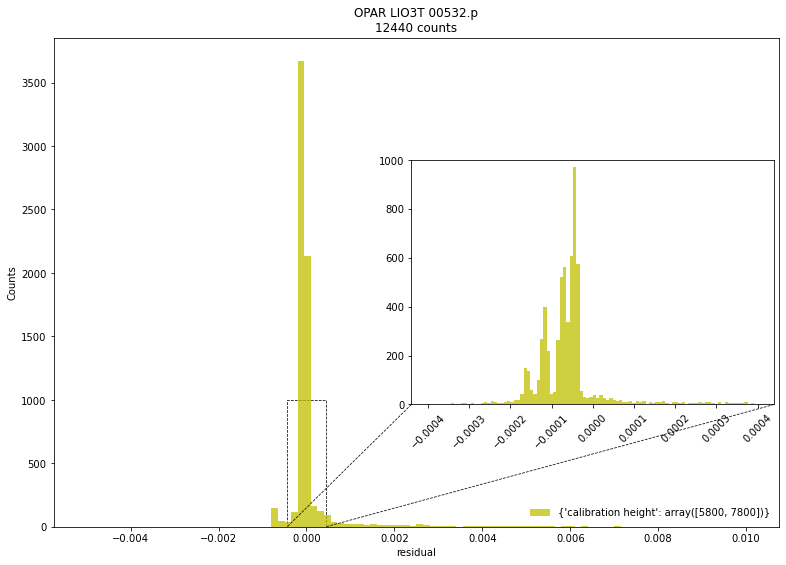

In [18]:
ff, ax = plt.subplots(figsize=[13,9])
# ax.hist(allstat, bins=100, range=(-0.01, 0.02), alpha = 0.75, color='r', label = new.attrs)
ax.hist(allstat2, bins=100, range=(-0.005, 0.01), alpha = 0.75, color='y', label = new2.attrs)
ax.legend(loc='lower right', frameon=False)
ax.set(title=f'OPAR {lidars} {new.channel[nb].values}\n{len(allstat)} counts',xlabel = 'residual', ylabel='Counts')
axins = inset_axes(ax, width="50%", height="50%", loc='center right')
# axins.hist(allstat, bins=100, range=(-0.0005, 0.0005), alpha = 0.75, color='r', label = new.attrs)
axins.hist(allstat2, bins=100, range=(-0.0004, 0.0004), alpha = 0.75, color='y', label = new2.attrs)
plt.setp(axins.get_xticklabels(), rotation=45)
axins.set_ylim(0, 1000)
pp, p1, p2 = mark_inset(ax, axins, loc1=3, loc2=4, fill=False, 
                        edgecolor="k", linestyle="--", zorder=0, linewidth=0.75)


In [159]:
len(allstat)

12440

## IPRAL

In [75]:
def residus_alt(new, channelnb):
    limite = np.where((new['range']>5000)&(new['range']<20000))[0]
    residues = new.isel(wavelength=channelnb)['calibrated']-new.isel(wavelength=channelnb)['simulated']
    residue = np.nansum(residues, axis=1)   
    return residue, residues


In [76]:
listfiles = list(sorted(Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/clouds/').glob('*20180418*_1440.nc')))
r_allClouds = []
# time_clouds=np.array([], dtype='datetime64[ns]'); time_clearsky=np.array([], dtype='datetime64[ns]')
for path in listfiles: 
    file = xr.open_dataset(path)
    r = residus_alt(file, 1)
    r_allClouds = np.concatenate((r_allClouds, r[0]))
#     time_clouds = np.concatenate((time_clouds, file['time'][r[0]>0.0005].values))
#     time_clearsky = np.concatenate((time_clearsky, file['time'][(r[0]>-0.0005)&(r[0]<0.0005)].values))
    limiteZ = (file['range']>5000)&(file['range']<20000)
    
    
listfiles = list(sorted(Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/clearsky').glob('*20180418*_1440.nc')))
print(listfiles)
r_allClear = []
# time_clouds=np.array([], dtype='datetime64[ns]'); time_clearsky=np.array([], dtype='datetime64[ns]')
for path in listfiles: 
    file = xr.open_dataset(path)
    r = residus_alt(file, 1)
    r_allClear = np.concatenate((r_allClear, r[0]))
#     time_clouds = np.concatenate((time_clouds, file['time'][r[0]>0.0005].values))
#     time_clearsky = np.concatenate((time_clearsky, file['time'][(r[0]>-0.0005)&(r[0]<0.0005)].values))
    limiteZ = (file['range']>5000)&(file['range']<20000)


[]


In [77]:
r_allClouds, r_allClear

(array([ 2.56594889e-04, -1.13002773e-04, -1.79301507e-05, ...,
         1.11440768e-05,  1.28134054e-04, -1.22007192e-03]),
 [])

[Text(0.5, 1.0, 'Residue between normalized and molecular signal integral on the altitude\n/homedata/nmpnguyen/IPRAL/RF/Calibrated\n2759 profils'),
 Text(0, 0.5, 'Occurence')]

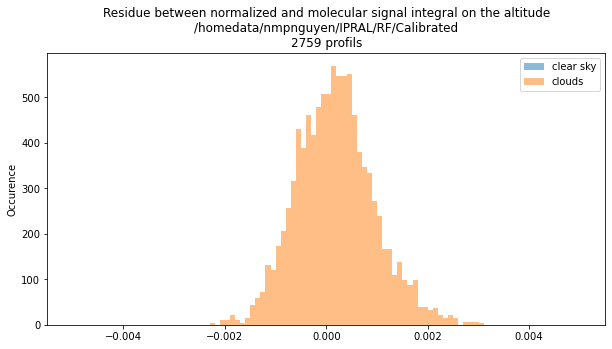

In [79]:
# Normalize by Density
kwargs = dict(alpha=0.5, bins=100, range=[-0.005, 0.005], density=True, stacked=True)
# Histogram
f1, ax = plt.subplots(figsize=[10,5])
(n, bins, patches )= ax.hist(r_allClear, **kwargs, label='clear sky')
(n, bins, patches )= ax.hist(r_allClouds, **kwargs, label='clouds')
ax.legend(loc='best')
ax.set(title = f'Residue between normalized and molecular signal integral on the altitude\n/homedata/nmpnguyen/IPRAL/RF/Calibrated\n{len(r_allClouds)+len(r_allClear)} profils',
      ylabel='Occurence')


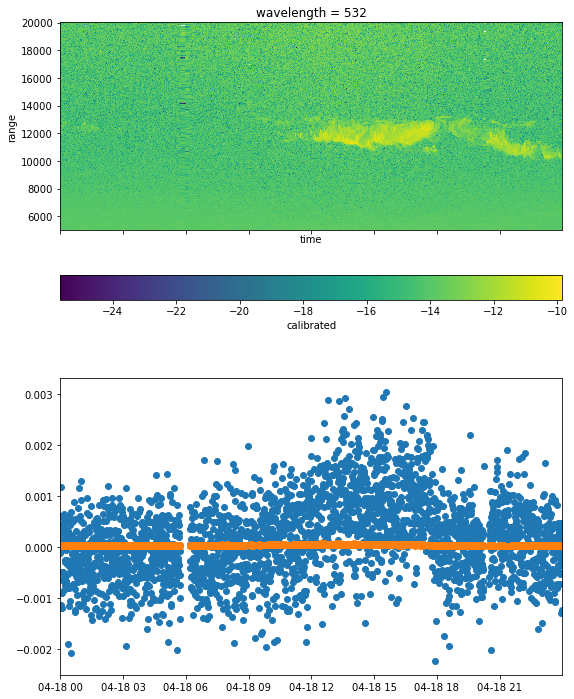

In [108]:
# plot un example ayant de nuage
fg, (ax, ax2) = plt.subplots(figsize=[9,12], nrows=2, sharex=True)
np.log(file['calibrated'].isel(wavelength=1, range=limiteZ)).plot(x='time', y='range', ax=ax, 
                                                                  cbar_kwargs={'orientation': 'horizontal'})
# ax.set_ylim(0,20000)
# ax2 = ax.twinx()
# sc = ax2.scatter(x= file['time'].values, y=np.array([2000]*len(file['time'])), c=np.abs(r_allClouds), s=50, cmap=plt.cm.jet)
# ax2.set_ylim(0,20000)
# fg.colorbar(sc)
# sc.set_clim(-0.002, 0.002)
ax2.scatter(file['time'].values, r_allClouds)
ax2.scatter(file['time'].values, np.amax(r[1], axis=1))

In [38]:
np.sort(r_allClear)[:int(0.95*len(r_allClear))]
# int(0.95*len(r_allClear))

percent=0.9
l=0
r=0.0005
sigma=r/2
while True:
    rapport = len(r_allClear[np.abs(r_allClear)>sigma])/len(r_allClear)
    if np.isclose(rapport, percent, rtol=1e-02):
        break
    elif (rapport > percent):
        l=sigma
        sigma=float(l+r)/2
    else:
        r=sigma
        sigma=float(l+r)/2
        
print(sigma)       

8.59375e-05


In [35]:
# r_allClear[(np.abs(r_allClear - 0.0005)).argmin()], r_allClear[2009]
np.isclose(96.4, 96.42, rtol=1e-02)

True

In [9]:
# Normalize by total profiles 

totalprofiles = len(r_allClouds)+ len(r_allClear)
Hclear = np.histogram(r_allClear, bins=100, range=[-0.05, 0.05])
Hclouds = np.histogram(r_allClouds, bins=100, range=[-0.05, 0.05])

dtHistogram = pd.DataFrame({'bins': np.linspace(-0.05, 0.05, 100), 
                           'probas_clear': 100*Hclear[0]/totalprofiles,
                           'probas_clouds': 100*Hclouds[0]/totalprofiles})


       bins  probas_clear  probas_clouds
0  -0.05000      0.000000       0.015320
1  -0.04899      0.000000       0.005107
2  -0.04798      0.000000       0.015320
3  -0.04697      0.000000       0.012767
4  -0.04596      0.000000       0.020426
..      ...           ...            ...
95  0.04596      0.000000       0.043406
96  0.04697      0.002553       0.035746
97  0.04798      0.005107       0.025533
98  0.04899      0.000000       0.022980
99  0.05000      0.000000       0.015320

[100 rows x 3 columns]


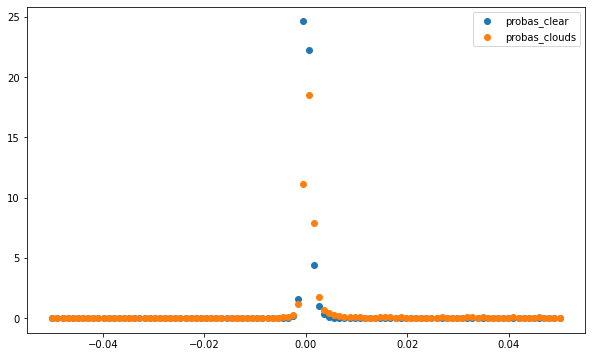

In [10]:


print(dtHistogram)
fg, ax = plt.subplots(figsize=[10,6])
ax.scatter(x= dtHistogram['bins'], y=dtHistogram['probas_clear'], label='probas_clear')
ax.scatter(x= dtHistogram['bins'], y=dtHistogram['probas_clouds'], label='probas_clouds')
ax.legend()

# ax.bar(x= dtHistogram['bins'], height=dtHistogram['probas_clear'], align='center', width=1)
# ax.bar(x= dtHistogram['bins'], height=dtHistogram['probas_clouds'], align='center', width=1)


#### --------------------------------------------------------------------------

In [161]:
all_residus = np.array([])
all_time = np.array([])
for l in sorted(Path('/homedata/nmpnguyen/IPRAL/RF').glob('**/532/*residus.txt')):
    with open(l, 'r') as f:
        print(l)
#         data = np.array([line.strip() for line in f.readlines() if line.find('calibration')!=0])
        data = np.array([line.strip() for line in f.readlines()])
        residus = np.array([float(data[i].split(',')[0]) for i in range(1, len(data))])
        time = np.array([datetime.strptime(data[i].split(',')[1].split('.')[0], '%Y-%m-%dT%H:%M:%S') for i in range(1, len(data))])
#         f, ax = plt.subplots(figsize=[10,6])
#         plt.rcParams['savefig.facecolor']='white'
#         ax.scatter(time, residus)
#         ax.set(title = str(l), ylabel='Residus integral on altitude (by profile)', xlabel='time')
#         plt.savefig(Path('/homedata/nmpnguyen/OPAR/Processed/RF/', l.name.split('residus.txt')[0], l.name.split('.txt')[0]+'.png'))
#         plt.close()
    all_residus = np.append(all_residus, residus)
    all_time = np.append(all_time, time)

/homedata/nmpnguyen/IPRAL/RF/20200122/532/ipral_1a_Lz1R15mF30sPbck_v01_20200122_000000_1440_residus.txt
/homedata/nmpnguyen/IPRAL/RF/20200123/532/ipral_1a_Lz1R15mF30sPbck_v01_20200123_000000_1440_residus.txt
/homedata/nmpnguyen/IPRAL/RF/20200206/532/ipral_1a_Lz1R15mF30sPbck_v01_20200206_000000_1440_residus.txt
/homedata/nmpnguyen/IPRAL/RF/20200207/532/ipral_1a_Lz1R15mF30sPbck_v01_20200207_000000_1440_residus.txt
/homedata/nmpnguyen/IPRAL/RF/20200519/532/ipral_1a_Lz1R15mF30sPbck_v01_20200519_000000_1440_residus.txt


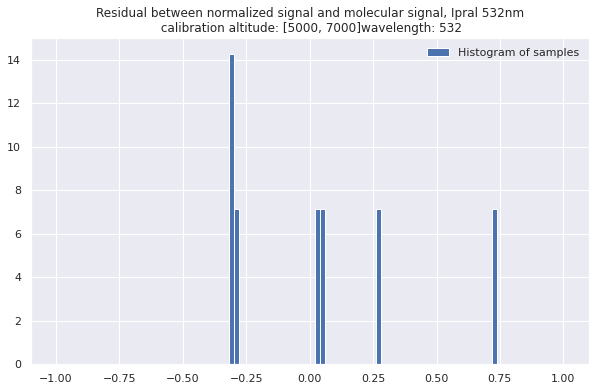

In [133]:
f, ax = plt.subplots(figsize=[10,6])
# plt.rcParams.update({"axes.facecolor" : "white"})
# counts, bins = np.histogram(all_residus, density=True)
(n, bins, patches )= ax.hist(all_residus[~np.isnan(all_residus)], bins=100, density=True,
                             label="Histogram of samples", range=[-1, 1])
# ax.axvline(bounds[3], color='r')
# ax.axvline(bounds[5], color='r')
#Compute probability density function
# bin_centers = 0.5*(bins[1:] + bins[:-1])
# mu, std = stats.norm.fit(all_residus[~np.isnan(all_residus)])
# pdf = stats.norm.pdf(x = bin_centers, loc=mu, scale=std)
# ax.plot(bin_centers, pdf, label="PDF",color='black') #Plot PDF
ax.legend(loc='best', frameon=False)
ax.set_title(f'Residual between normalized signal and molecular signal, Ipral 532nm\n {data[0]}')
plt.savefig(Path('/homedata/nmpnguyen/IPRAL/RF', 'residus-report-Ipral-'+data[0]+'.png'))

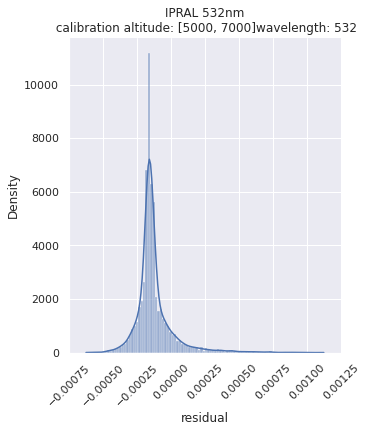

In [163]:
sns.set(rc={'figure.figsize': (12, 9)})
g = sns.displot(all_residus[all_residus!=0], stat="density", kde=True, bins=100)#
g.set(title=f'IPRAL 532nm\n {data[0]}',
     xlabel = 'residual')
g.set_xticklabels(rotation=45)  
# g.set(xlim=(-0.01, 0.01))
# plt.savefig(Path('/homedata/nmpnguyen/IPRAL/RF', 'residus-report-Ipral-'+data[0]+'.png'))

In [168]:
bounds = np.arange(all_residus.min(), all_residus.max(), 0.00025)
print(bounds)

[-0.000623 -0.000373 -0.000123  0.000127  0.000377  0.000627  0.000877]


In [22]:
len(np.where((all_residus>bounds[5]) & (all_residus<bounds[8]))[0])/len(all_residus)
list_time = all_time[np.where((all_residus >= bounds[3]) & (all_residus <= bounds[5]))[0]]
print(len(all_time))
print(list_time[4000:4010])

5907
[datetime.datetime(2020, 5, 19, 18, 54, 35)
 datetime.datetime(2020, 5, 19, 18, 55, 5)
 datetime.datetime(2020, 5, 19, 18, 55, 36)
 datetime.datetime(2020, 5, 19, 18, 56, 6)
 datetime.datetime(2020, 5, 19, 18, 56, 36)
 datetime.datetime(2020, 5, 19, 18, 57, 6)
 datetime.datetime(2020, 5, 19, 18, 57, 37)
 datetime.datetime(2020, 5, 19, 18, 58, 7)
 datetime.datetime(2020, 5, 19, 18, 58, 37)
 datetime.datetime(2020, 5, 19, 18, 59, 8)]


In [131]:
# from tqdm.notebook import tqdm
# from tqdm import tqdm.notebook as tqdm
allstat = np.array([], dtype=np.float)
nb = 0
listfiles = list(sorted(Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/').glob('*_1440.nc')))

for file in listfiles:
#     print(file)
    new = xr.open_dataset(file)
    stat = residus_alt(new, nb)[0]
    allstat = np.concatenate((allstat, stat))

In [132]:
new['wavelength']
allstat.max(), allstat.min()

(0.021425999805593537, -0.012801238361310186)

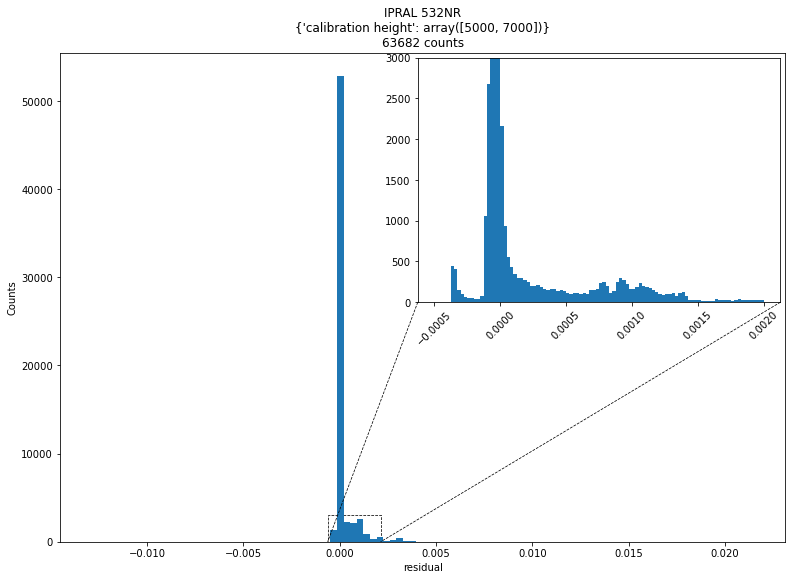

In [148]:
# np.histogram(allstat, bins=100)
ff, ax = plt.subplots(figsize=[13,9])
ax.hist(allstat, bins=100)
ax.set(title=f'IPRAL {new.wavelength[nb].values}NR\n {new.attrs} \n{len(allstat)} counts',xlabel = 'residual', ylabel='Counts')
axins = inset_axes(ax, width="50%", height="50%", loc='upper right')
axins.hist(allstat, bins=100, range=(-0.0005, 0.002))
plt.setp(axins.get_xticklabels(), rotation=45)
axins.set_ylim(0, 3000)
pp, p1, p2 = mark_inset(ax, axins, loc1=3, loc2=4, fill=False, 
                        edgecolor="k", linestyle="--", zorder=0, linewidth=0.75)


### ORACLES ER2

In [100]:
all_residus = np.array([])
all_time = np.array([])
for l in sorted(Path('/homedata/nmpnguyen/ORACLES-ER2/RF').glob('**/355/*residus.txt')):
    with open(l, 'r') as f:
        print(l)
        data = np.array([line.strip() for line in f.readlines()])
        residus = np.array([float(data[i].split(',')[0]) for i in range(1, len(data))])
        time = np.array([data[i].split(',')[1] for i in range(1, len(data))])
    all_residus = np.append(all_residus, residus)
    all_time = np.append(all_time, time)

/homedata/nmpnguyen/ORACLES-ER2/RF/HSRL2_ER2_20160819_R8/355/HSRL2_ER2_20160819_R8_residus.txt
/homedata/nmpnguyen/ORACLES-ER2/RF/HSRL2_ER2_20160823_R8/355/HSRL2_ER2_20160823_R8_residus.txt
/homedata/nmpnguyen/ORACLES-ER2/RF/HSRL2_ER2_20160912_R8/355/HSRL2_ER2_20160912_R8_residus.txt
/homedata/nmpnguyen/ORACLES-ER2/RF/HSRL2_ER2_20160920_R8/355/HSRL2_ER2_20160920_R8_residus.txt


Text(0.5, 1.0, 'Residual between normalized signal and molecular signal, ORACLES-ER2 355nm\n calibration altitude: [17700, 19000]wavelength: 355')

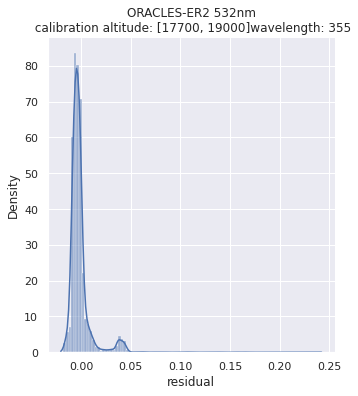

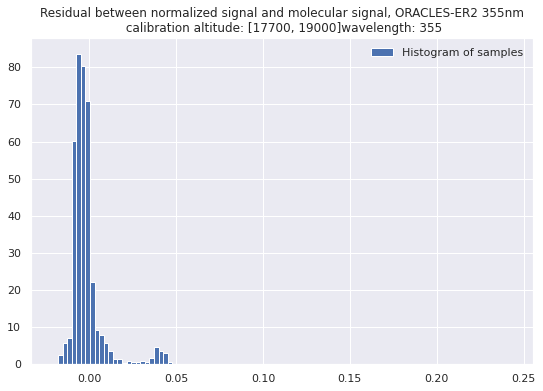

In [102]:
sns.set(rc={'figure.figsize': (12, 9)})
g = sns.displot(all_residus[all_residus!=0], stat="density", kde=True, bins=100)#
g.set(title=f'ORACLES-ER2 532nm\n {data[0]}',
     xlabel = 'residual')
plt.savefig(Path('/homedata/nmpnguyen/ORACLES-ER2/RF', 'residus-report-'+data[0]+'.png'))

f, ax = plt.subplots(figsize=[9,6])
# plt.rcParams.update({"axes.facecolor" : "white"})
# counts, bins = np.histogram(all_residus, density=True)
(n, bins, patches )= ax.hist(all_residus[all_residus!=0], bins=100, density=True,
                             label="Histogram of samples")
#Compute probability density function
# bin_centers = 0.5*(bins[1:] + bins[:-1])
# mu, std = stats.norm.fit(all_residus[~np.isnan(all_residus)])
# pdf = stats.norm.pdf(x = bin_centers, loc=mu, scale=std)
# ax.plot(bin_centers, pdf, label="PDF",color='black') #Plot PDF
ax.legend(loc='best', frameon=False)
ax.set_title(f'Residual between normalized signal and molecular signal, ORACLES-ER2 355nm\n {data[0]}')


In [43]:
def residus_alt(new, channelnb):
    limite = np.where((new['altitude']>5000)&(new['altitude']<20000))[0]
    residue = np.nansum(new.isel(wavelength=channelnb, altitude=limite)['calibrated']-new.isel(wavelength=channelnb, altitude=limite)['molecular'], axis=1)
#     residues = np.nansum([new.isel(wavelength=channelnb)['calibrated'],-new.isel(wavelength=channelnb)['simulated']], axis=0)
#     residues = np.nanmean(residues, axis=1)
    return residue


In [78]:
allstat = np.array([], dtype=np.float)
for file in sorted(Path('/homedata/nmpnguyen/ORACLES-ER2/RF/Calibrated/').glob('*_R8.h5')):
    new = xr.open_dataset(file)
    stat = residus_alt(new, 0)
    allstat = np.concatenate((allstat, stat))


(0.0, 250.0)

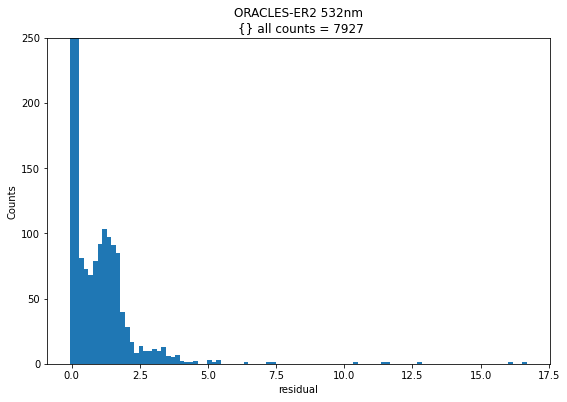

In [82]:
np.histogram(allstat, bins=100)
ff, ax = plt.subplots(figsize=[9,6])
ax.hist(allstat, bins=100)
ax.set(title=f'ORACLES-ER2 {new.wavelength[1].values}nm\n {new.attrs} all counts = {len(allstat)}',
       xlabel = 'residual', ylabel='Counts')
ax.set_ylim(0,250)

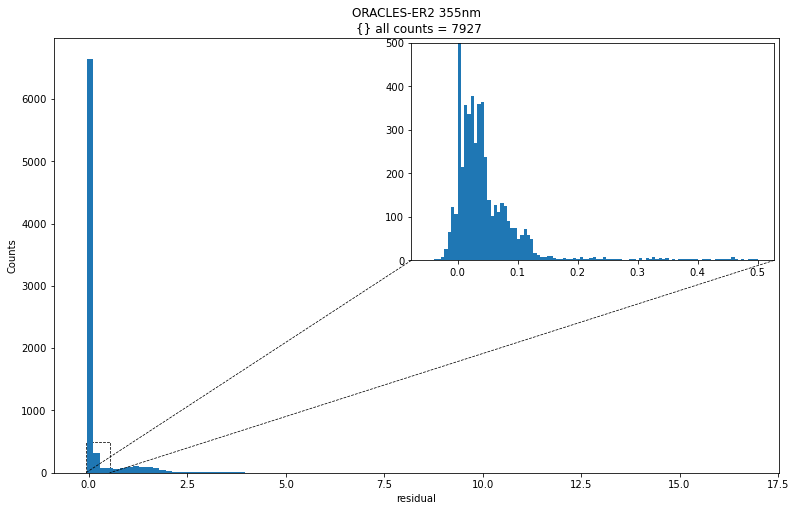

In [90]:
f, ax = plt.subplots(figsize=[13,8])
ax.hist(allstat, bins=100)
ax.set(title=f'ORACLES-ER2 {new.wavelength[0].values}nm\n {new.attrs} all counts = {len(allstat)}',
       xlabel = 'residual', ylabel='Counts')
# axins = zoomed_inset_axes(parent_axes=ax, loc='upper right', zoom=0.5, border)
axins = inset_axes(ax, width="50%", height="50%", loc='upper right')
axins.hist(allstat, bins=100, range=(-0.05, 0.5))
axins.set_ylim(0, 500)
pp, p1, p2 = mark_inset(ax, axins, loc1=3, loc2=4, fill=False, edgecolor="k", linestyle="--", zorder=0, linewidth=0.75)

#### RESIDUS VERSION 2

In [171]:
list_files = list(sorted(Path('/homedata/nmpnguyen/IPRAL/RF/Calibrated/').glob('*.nc')))
len(list_files)

27

In [174]:
residus = []
for pathfile in list_files:
    data = xr.open_dataset(pathfile)
    residual = np.zeros(len(data['time']))
    for z in range(len(data['range'])):
        residual = residual + (data['calibrated'][0,:,z] - data['simulated'][0,:,z])
    residus.append(residual)

KeyboardInterrupt: 

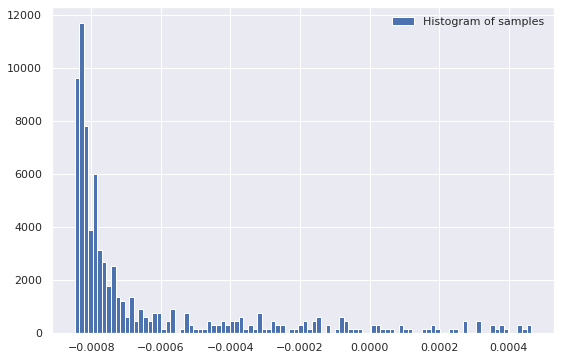

In [180]:
f, ax = plt.subplots(figsize=[9,6])
(n, bins, patches )= ax.hist(residus[residus!=0], bins=100, density=True,
                             label="Histogram of samples")
#Compute probability density function
# bin_centers = 0.5*(bins[1:] + bins[:-1])
# mu, std = stats.norm.fit(all_residus[~np.isnan(all_residus)])
# pdf = stats.norm.pdf(x = bin_centers, loc=mu, scale=std)
# ax.plot(bin_centers, pdf, label="PDF",color='black') #Plot PDF
ax.legend(loc='best', frameon=False)
# ax.set_title(f'Residual between normalized signal and molecular signal, ORACLES-ER2 355nm\n {data[0]}')


In [186]:
residus[0]['time']

<xarray.DataArray 'time' (time: 445)>
array(['2019-02-15T11:48:12.000000256', '2019-02-15T11:48:42.000000000',
       '2019-02-15T11:49:12.000000000', ..., '2019-02-15T16:02:38.000000000',
       '2019-02-15T16:03:49.000000256', '2019-02-15T16:04:55.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time        (time) datetime64[ns] 2019-02-15T11:48:12.000000256 ... 2019-...
    wavelength  int64 532

## Etude Coef de Corrélation et Résidus